# Alignment

The goal of this notebook is to align files using DTW, weakly-ordered Segmental DTW, or strictly-ordered Segmental DTW.

In [1]:
%matplotlib inline
%load_ext Cython

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
import os.path
from pathlib import Path
import pickle
import multiprocessing
import time
import gc
from numba import jit
import subprocess
import pandas as pd

In [3]:
env = os.environ.copy()

# Add $HOME/bin to the PATH to include installations of sonic-annotator / vamp plugins
env['PATH'] = os.path.expanduser('~/bin') + ':' + env['PATH']

## Align with DTW

The following cell contains a cython implementation of basic DTW.

In [4]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

import sys
import time


DTYPE_INT32 = np.int32
ctypedef np.int32_t DTYPE_INT32_t

DTYPE_FLOAT = np.float64
ctypedef np.float64_t DTYPE_FLOAT_t

cdef DTYPE_FLOAT_t MAX_FLOAT = float('inf')

# careful, without bounds checking can mess up memory - also can't use negative indices I think (like x[-1])
@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_Cost_To_AccumCostAndSteps(Cin, parameter):
    '''
    Inputs
        C: The cost Matrix
    '''


    '''
    Section for checking and catching errors in the inputs
    '''

    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] C
    try:
        C = np.array(Cin, dtype=DTYPE_FLOAT)
    except TypeError:
        print(bcolors.FAIL + "FAILURE: The type of the cost matrix is wrong - please pass in a 2-d numpy array" + bcolors.ENDC)
        return [-1, -1, -1]
    except ValueError:
        print(bcolors.FAIL + "FAILURE: The type of the elements in the cost matrix is wrong - please have each element be a float (perhaps you passed in a matrix of ints?)" + bcolors.ENDC)
        return [-1, -1, -1]

    cdef np.ndarray[np.uint32_t, ndim=1] dn
    cdef np.ndarray[np.uint32_t, ndim=1] dm
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=1] dw
    # make sure dn, dm, and dw are setup
    # dn loading and exception handling
    if ('dn'  in parameter.keys()):
        try:

            dn = np.array(parameter['dn'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dn (row steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "The type of the elements in dn (row steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dn = np.array([1, 1, 0], dtype=np.uint32)
    # dm loading and exception handling
    if 'dm'  in parameter.keys():
        try:
            dm = np.array(parameter['dm'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dm (col steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE: The type of the elements in dm (col steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        print(bcolors.FAIL + "dm (col steps) was not passed in (gave default value [1,0,1]) " + bcolors.ENDC)
        dm = np.array([1, 0, 1], dtype=np.uint32)
    # dw loading and exception handling
    if 'dw'  in parameter.keys():
        try:
            dw = np.array(parameter['dw'], dtype=DTYPE_FLOAT)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dw (step weights) is wrong - please pass in a 1-d numpy array that holds floats" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE:The type of the elements in dw (step weights) is wrong - please have each element be a float (perhaps you passed ints or a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.float64)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dw = np.array([1, 1, 1], dtype=DTYPE_FLOAT)
        print(bcolors.FAIL + "dw (step weights) was not passed in (gave default value [1,1,1]) " + bcolors.ENDC)

    
    '''
    Section where types are given to the variables we're going to use 
    '''
    # create matrices to store our results (D and E)
    cdef DTYPE_INT32_t numRows = C.shape[0] # only works with np arrays, use np.shape(x) will work on lists? want to force to use np though?
    cdef DTYPE_INT32_t numCols = C.shape[1]
    cdef DTYPE_INT32_t numDifSteps = np.size(dw)

    cdef unsigned int maxRowStep = max(dn)
    cdef unsigned int maxColStep = max(dm)

    cdef np.ndarray[np.uint32_t, ndim=2] steps = np.zeros((numRows,numCols), dtype=np.uint32)
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost = np.ones((maxRowStep + numRows, maxColStep + numCols), dtype=DTYPE_FLOAT) * MAX_FLOAT

    cdef DTYPE_FLOAT_t bestCost
    cdef DTYPE_INT32_t bestCostIndex
    cdef DTYPE_FLOAT_t costForStep
    cdef unsigned int row, col
    cdef unsigned int stepIndex

    '''
    The start of the actual algorithm, now that all our variables are set up
    '''
    # initializing the cost matrix - depends on whether its subsequence DTW
    # essentially allow us to hop on the bottom anywhere (so could start partway through one of the signals)
    if parameter['SubSequence']:
        for col in range(numCols):
            accumCost[maxRowStep, col + maxColStep] = C[0, col]
    else:
        accumCost[maxRowStep, maxColStep] = C[0,0]

    # filling the accumulated cost matrix
    for row in range(maxRowStep, numRows + maxRowStep, 1):
        for col in range(maxColStep, numCols + maxColStep, 1):
            bestCost = accumCost[<unsigned int>row, <unsigned int>col] # initialize with what's there - so if is an entry point, then can start low
            bestCostIndex = 0
            # go through each step, find the best one
            for stepIndex in range(numDifSteps):
                #costForStep = accumCost[<unsigned int>(row - dn[<unsigned int>(stepIndex)]), <unsigned int>(col - dm[<unsigned int>(stepIndex)])] + dw[<unsigned int>(stepIndex)] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                costForStep = accumCost[<unsigned int>((row - dn[(stepIndex)])), <unsigned int>((col - dm[(stepIndex)]))] + dw[stepIndex] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                if costForStep < bestCost:
                    bestCost = costForStep
                    bestCostIndex = stepIndex
            # save the best cost and best cost index
            accumCost[row, col] = bestCost
            steps[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)] = bestCostIndex

    # return the accumulated cost along with the matrix of steps taken to achieve that cost
    return [accumCost[maxRowStep:, maxColStep:], steps]

@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_GetPath(np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost, np.ndarray[np.uint32_t, ndim=2] stepsForCost, parameter):
    '''

    Parameter should have: 'dn', 'dm', 'dw', 'SubSequence'
    '''

    cdef np.ndarray[unsigned int, ndim=1] dn
    cdef np.ndarray[unsigned int, ndim=1] dm
    cdef np.uint8_t subseq
    cdef np.int32_t startCol # added
    # make sure dn, dm, and dw are setup
    if ('dn'  in parameter.keys()):
        dn = parameter['dn']
    else:
        dn = np.array([1, 1, 0], dtype=DTYPE_INT32)
    if 'dm'  in parameter.keys():
        dm = parameter['dm']
    else:
        dm = np.array([1, 0, 1], dtype=DTYPE_INT32)
    if 'SubSequence' in parameter.keys():
        subseq = parameter['SubSequence']
    else:
        subseq = 0
    
    # added START
    if 'startCol' in parameter.keys(): 
        startCol = parameter['startCol']
    else:
        startCol = -1
    # added END

    cdef np.uint32_t numRows
    cdef np.uint32_t numCols
    cdef np.uint32_t curRow
    cdef np.uint32_t curCol
    cdef np.uint32_t endCol
    cdef DTYPE_FLOAT_t endCost

    numRows = accumCost.shape[0]
    numCols = accumCost.shape[1]

    # either start at the far corner (non sub-sequence)
    # or start at the lowest cost entry in the last row (sub-sequence)
    # where all of the signal along the row has been used, but only a 
    # sub-sequence of the signal along the columns has to be used
    curRow = numRows - 1
    if subseq:
        curCol = np.argmin(accumCost[numRows - 1, :])
    else:
        curCol = numCols - 1
        
    # added - if specified, overrides above
    if startCol >= 0:
        curCol = startCol

    endCol = curCol
    endCost = accumCost[curRow, curCol]

    cdef np.uint32_t curRowStep
    cdef np.uint32_t curColStep
    cdef np.uint32_t curStepIndex


    cdef np.ndarray[np.uint32_t, ndim=2] path = np.zeros((2, numRows + numCols), dtype=np.uint32) # make as large as could need, then chop at the end
    path[0, 0] = curRow
    path[1, 0] = curCol

    cdef np.uint32_t stepsInPath = 1 # starts at one, we add in one before looping
    cdef np.uint32_t stepIndex = 0
    cdef np.int8_t done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)
    while not done:
        if accumCost[curRow, curCol] == MAX_FLOAT:
            print('A path is not possible')
            break

        # you're done if you've made it to the bottom left (non sub-sequence)
        # or just the bottom (sub-sequence)
        # find the step size
        curStepIndex = stepsForCost[curRow, curCol]
        curRowStep = dn[curStepIndex]
        curColStep = dm[curStepIndex]
        # backtrack by 1 step
        curRow = curRow - curRowStep
        curCol = curCol - curColStep
        # add your new location onto the path
        path[0, stepsInPath] = curRow
        path[1, stepsInPath] = curCol
        stepsInPath = stepsInPath + 1
        # check to see if you're done
        done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)

    # reverse the path (a matrix with two rows) and return it
    return [np.fliplr(path[:, 0:stepsInPath]), endCol, endCost]

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [5]:
def alignDTW(featfile1, featfile2, steps, weights, downsample, outfile = None, profile = False):
    
    F1 = np.load(featfile1) # 12 x N
    F2 = np.load(featfile2) # 12 x M
    if max(F1.shape[1], F2.shape[1]) / min(F1.shape[1], F2.shape[1]) >= 2: # no valid path possible
        print("DTW: No valid path possible")
        if outfile:
            pickle.dump(None, open(outfile, 'wb'))
        return None
    times = []
    times.append(time.time())
    C = 1 - F1[:,0::downsample].T @ F2[:,0::downsample] # cos distance metric
    times.append(time.time())

    dn = steps[:,0].astype(np.uint32)
    dm = steps[:,1].astype(np.uint32)
    parameters = {'dn': dn, 'dm': dm, 'dw': weights, 'SubSequence': False}
    [D, s] = DTW_Cost_To_AccumCostAndSteps(C, parameters)
    times.append(time.time())
    [wp, endCol, endCost] = DTW_GetPath(D, s, parameters)
    times.append(time.time())
    if outfile:
        pickle.dump(wp, open(outfile, 'wb'))
    
    if profile:
        return wp, np.diff(times)
    else:
        return wp

In [6]:
def alignDTW_batch(querylist, featdir1, featdir2, outdir, n_cores, steps, weights, downsample):
    
    outdir.mkdir(parents=True, exist_ok=True)
    
    # prep inputs for parallelization
    inputs = []
    with open(querylist, 'r') as f:
        for line in f:
            parts = line.strip().split(' ')
            assert len(parts) == 2
            featfile1 = (featdir1 / parts[0]).with_suffix('.npy')
            featfile2 = (featdir2 / parts[1]).with_suffix('.npy')
            queryid = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
            outfile = (outdir / queryid).with_suffix('.pkl')
            if os.path.exists(outfile):
                print(f"Skipping {outfile}")
            else:
                inputs.append((featfile1, featfile2, steps, weights, downsample, outfile))

    # process files in parallel
    pool = multiprocessing.Pool(processes = n_cores)
    pool.starmap(alignDTW, inputs)
    
    return

Align a single pair of audio files

In [7]:
featfile1 = 'features/clean/Chopin_Op068No3/Chopin_Op068No3_Tomsic-1995_pid9190-11.npy'
featfile2 = 'features/clean/Chopin_Op068No3/Chopin_Op068No3_Cortot-1951_pid9066b-19.npy'
outfile = 'test.pkl'
steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
weights = np.array([2,3,3])
downsample = 1
wp = alignDTW(featfile1, featfile2, steps, weights, downsample, outfile = outfile)

DTW: No valid path possible


Align all pairs of audio files

In [8]:
query_list = 'cfg_files/query.test.list'
featdir1 = Path('features/clean')
featdir2 = Path('features/clean') # in case you want to align clean vs noisy
outdir = Path('experiments_test/dtw_clean')
n_cores = 10
steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
weights = np.array([2,3,3])
downsample = 1
inputs = alignDTW_batch(query_list, featdir1, featdir2, outdir, n_cores, steps, weights, downsample)

Skipping experiments_test/dtw_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Ax-1985_pid9179-07.pkl
Skipping experiments_test/dtw_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Bacha-1998_pid9166e-08.pkl
Skipping experiments_test/dtw_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Barbosa-1983_pid9174-15.pkl
Skipping experiments_test/dtw_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Ben-Or-1989_pid9161-13.pkl
Skipping experiments_test/dtw_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Biret-1990_pid9062-15.pkl
Skipping experiments_test/dtw_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Brailowsky-1960_pid9060-15.pkl
Skipping experiments_test/dtw_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Chiu-1999_pid9048-15.pkl
Skipping experiments_test/dtw_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Clidat-1994_pid9067-15.pkl
Skipping experiments_test/

## Align with OnlineDTW

OnlineDTW uses FlexDTW in an online fashion. Before implementing OnlineDTW, first implement FlexDTW. 

### FlexDTW Implementation
From https://github.com/HMC-MIR/FlexDTW

In [9]:
@jit(nopython=True)
def flexdtw_alt(C, steps, weights, buffer=1):
    '''
    Implementation of DTW Star version 0.2a.  
    
    Inputs
    C: pairwise cost matrix
    steps: a numpy matrix specifying the allowable transitions.  It should be of
        dimension (L, 2), where each row specifies (row step, col step)
    weights: a array that specifies the multiplicative weights for each transition
        type.  The length of this array must match the number of possible transitions.
    buffer: specifies 
    
    Outputs
    best_cost: the best average cost per manhattan block
    path: the estimated warping path, specified as a 2xN array
    debug: Debugging information for examining the average cost per manhattan block for each 
        of the candidate ending positions.
    '''
    
    # initialize
    D = np.zeros(C.shape)
    B = np.zeros(C.shape, dtype=np.int8)
    P = np.zeros(C.shape, dtype=np.int32)
    D[0,:] = C[0,:]
    D[:,0] = C[:,0]
    
    # DP
    for row in range(1,C.shape[0]):
        for col in range(1, C.shape[1]):
            
            mincost = np.inf
            minidx = -1
            bestrprev = -1
            bestcprev = -1
            
            # find best transition
            for stepidx, step in enumerate(steps):
                
                (rstep, cstep) = step
                prevrow = row - rstep
                prevcol = col - cstep
                
                if prevrow >= 0 and prevcol >= 0:
                    
                    pathcost = D[prevrow, prevcol] + C[row, col] * weights[stepidx]
                    
                    if pathcost < mincost:
                        
                        mincost = pathcost
                        minidx = stepidx
                        bestrprev = prevrow
                        bestcprev = prevcol
            
            # update D, B, P
            D[row, col] = mincost
            B[row, col] = minidx
            if bestrprev == 0:
                P[row, col] = bestcprev
            elif bestcprev == 0:
                P[row, col] = -1*bestrprev
            else:
                P[row, col] = P[bestrprev, bestcprev]
            
    #  backtrack
    best_cost, best_r, best_c, debug = find_best_endpoint(D, P, buffer)
    path = backtrace_flexdtw(D, B, steps, best_r, best_c)
    path.reverse()
    path = np.array(path).T 
    
    return best_cost, path, debug, D, B, P

In [10]:
@jit(nopython=True)
def find_best_endpoint(D, P, buffer):
    '''
    Determines the best location to begin backtracking from by comparing the average path cost
    per manhattan block.
    
    Inputs
    D: the cumulative cost matrix
    P: the matrix specifying the starting location of the alignment path
    buffer: specifies the length of a buffer region (in frames) to avoid short degenerate alignment paths
        near the corners of the pairwise cost matrix.  This can be thought of as the minimum length that
        needs to match in order to be considered a valid alignment path.
    
    Outputs
    best_cost: the best average path cost per manhattan block
    best_r: the row index of the best endpoint
    best_c: the column index of the best endpoint
    debug: debugging information for examining the average cost per manhattan block for each 
        of the candidate ending positions
    '''
    
    # consider last row and column as candidates
    candidates = [(D.shape[0]-1,i) for i in range(buffer, D.shape[1])] + [(i, D.shape[1]-1) for i in range(buffer, D.shape[0]-1)][::-1]
    
    best_cost = np.inf
    best_r, best_c = -1, -1
    debug = []
    
    for i, (r,c) in enumerate(candidates):
                
        # get alignment start location
        if P[r,c] >= 0:
            rstart, cstart = 0, P[r,c]
        else:
            rstart, cstart = -P[r,c], 0
            
        # calculate average cost per manhattan block
        mdist = (r - rstart) + (c - cstart) # manhattan distance
        avg_cost_per_mb = D[r,c] / mdist
        
        # keep best
        if avg_cost_per_mb < best_cost:
            best_cost = avg_cost_per_mb
            best_r, best_c = r, c
            
        # debugging info
        if r == D.shape[0]-1:
            debug.append((c-D.shape[1]+1, avg_cost_per_mb, r, c))
        else:
            debug.append((D.shape[0]-1-r, avg_cost_per_mb, r, c))
    
    return best_cost, best_r, best_c, debug

In [11]:
@jit(nopython=True)
def backtrace_flexdtw(D, B, steps, rstart, cstart):
    '''
    Backtraces through the cumulative cost matrix D starting from a specified location.
    
    Arguments:
    D: cumulative cost matrix
    B: backtrace matrix
    steps: a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    rstart: the row index to start backtracking from
    cstart: the column index to start backtracking from
    
    Outputs
    path: a python list of (row, col) coordinates for the optimal path.
    '''
    pos = (rstart, cstart)
    path = []
    path.append(pos)
    while(pos[0] != 0 and pos[1] != 0):
        (row, col) = pos
        stepidx = B[row, col]
        (rstep, cstep) = steps[stepidx]
        pos = (row-rstep, col-cstep)
        path.append(pos)
    
    return path

Now, with FlexDTW implemented, implement OnlineDTW
### OnlineDTW Implementation

In [12]:
def online_flex_dtw(C, steps, weights, buffer_fraction=0.5, L=1000):
    """
    Computes the optimal path through a cost matrix using an online method, taking windows of length L 
    and applying FlexDTW to each one.

    Inputs
    C: pairwise cost matrix
    steps: a numpy matrix specifying the allowable transitions.  It should be of
        dimension (L, 2), where each row specifies (row step, col step)
    weights: a array that specifies the multiplicative weights for each transition
        type.  The length of this array must match the number of possible transitions.
    buffer_fraction: specifies the length of a buffer region (in frames) to avoid short degenerate alignment paths
        near the corners of the pairwise cost matrix.  This can be thought of as the minimum length that
        needs to match in order to be considered a valid alignment path. The buffer length is the buffer_fraction times L.
    L: square window size to find path through

    
    Outputs
    best_cost: the best average cost per manhattan block
    full_path: the estimated warping path, specified as a 2xN array
    """

    if buffer_fraction > 1 or buffer_fraction < 0:
        raise ValueError("buffer_fraction argument must be between 0 and 1")
    buffer = int(L*buffer_fraction)
        

    # start at bottom left of 
    row = 0
    col = 0

    num_rows, num_cols = C.shape

    full_path = []

    # iterate while we can do full windows
    while(row < (num_rows - L) and col < (num_cols - L)):
        C_window = C[row:row+L, col:col+L]
        _, path, _, _, _, _ = flexdtw_alt(C_window, steps, weights, buffer=buffer)

        end_row, end_col = path[:, -1]

        # make path into global indexing instead of relative
        global_offset = np.zeros(path.shape, dtype=np.int64)
        global_offset[0, :] = row
        global_offset[1, :] = col
        path += global_offset

        row = row + end_row
        col = col + end_col
        
        full_path.append(path)

    # do last window, won't be full size
    start_row = row
    end_row = min(row + L, num_rows)

    start_col = col
    end_col = min(col + L, num_cols)

    C_window = C[start_row:end_row, start_col:end_col]
    buffer_size = min((end_row - start_row)/2, (end_col - start_col)/2)
    _, path, _, _, _, _ = flexdtw_alt(C_window, steps, weights, buffer=buffer_size)

    end_row, end_col = path[:, -1]

    # make path into global indexing instead of relative
    global_offset = np.zeros(path.shape, dtype=np.int64)
    global_offset[0, :] = row
    global_offset[1, :] = col
    path += global_offset
    
    row = row + end_row
    col = col + end_col

    full_path.append(path)

    
    # concatenate arrays along coordinate axis
    full_path = np.concatenate(full_path, axis=1)

    return full_path


In [13]:
def mapFrame(r, c, Dshape, frames=False):
    if frames: #  frames, use exact
        if r == Dshape[0]-1:
            val = c-D.shape[1]+1
        else:
            val = D.shape[0]-1-r
    else: # seconds, use approximate
        distr = np.abs(r-Dshape[0])
        distc = np.abs(c-Dshape[1])
        if distr < distc:
            val = c-Dshape[1]
        else:
            val = Dshape[0]-r
    return val

In [14]:
def L2norm(F):
    L2norm = np.sqrt(np.sum(F*F, axis = 0)) + 1e-9
    Fnorm = F / L2norm.reshape((1,-1))
    return Fnorm

In [15]:
def compute_cosdist_cost(F_query, F_ref):
    """
    Computes the cosine distance cost matrix for a reference feature matrix and a query feature matrix.
    """

    return 1 - L2norm(F_query).T @ L2norm(F_ref)

In [16]:
def getTimestamps(annotfile1, annotfile2):
    df1 = pd.read_csv(annotfile1, header=None, sep='\s+', skiprows=3) 
    df2 = pd.read_csv(annotfile2, header=None, sep='\s+', skiprows=3)
    
    # df_merged = df1.merge(df2, on=[2], how='left')
    # df_merged.to_csv("merged_test.csv")

    return np.array(df1[0]), np.array(df2[0])

In [17]:
def alignOnlineDTW(featfile1, featfile2, steps, weights, buffer_fraction=0.5, L=1000, outfile = None, profile = False):
    hop_sec = 512 / 22050
    F1 = np.load(featfile1) # 12 x N
    F2 = np.load(featfile2) # 12 x M
    if max(F1.shape[1], F2.shape[1]) / min(F1.shape[1], F2.shape[1]) >= 2: # no valid path possible   
        print("OnlineDTW: No valid path possible")
        if outfile:
            pickle.dump(None, open(outfile, 'wb'))
        return None
    times = []
    times.append(time.time())
    C = compute_cosdist_cost(F1, F2) # cos distance metric
    times.append(time.time())
    
    wp = online_flex_dtw(C, steps, weights, buffer_fraction = buffer_fraction, L = L)
    times.append(time.time())
    
    print('.', end = '')
    
    if outfile:
        pickle.dump(wp, open(outfile, 'wb'))
    
    if profile:
        return wp, np.diff(times)
    else:
        return wp

In [18]:
def alignOnlineDTW_batch(querylist, featdir1, featdir2, outdir, n_cores, steps, weights, L, buffer_fraction = 0.5):
    print("Entered alignOnlineDTW_batch")
    
    outdir.mkdir(parents=True, exist_ok=True)
    
    # prep inputs for parallelization
    inputs = []
    print("Preparing inputs")
    with open(querylist, 'r') as f:
        for line in f:
            parts = line.strip().split(' ')
            assert len(parts) == 2
            featfile1 = (featdir1 / parts[0]).with_suffix('.npy')
            featfile2 = (featdir2 / parts[1]).with_suffix('.npy')
            queryid = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
            outfile = (outdir / queryid).with_suffix('.pkl')
            if os.path.exists(outfile):
                print(f"Skipping {outfile}")
            else:
                inputs.append((featfile1, featfile2, steps, weights, buffer_fraction, L, outfile))
    
    n_inputs = len(inputs)
    
    print("Setting up multiprocessing for L = %d. %d cores, %d inputs" % (L, n_cores, n_inputs))
    # process files in parallel
    pool = multiprocessing.Pool(processes = n_cores)
    print("Started multiprocessing")
    pool.starmap(alignOnlineDTW, inputs)
    
    return

In [19]:
def align_match(audio_path1, audio_path2, outfile = None):
    # match_align_filepath = f"{os.path.basename(audio_path1)}__{os.path.basename(audio_path2)}.csv"
    # with open(match_align_filepath, 'w') as f:
    #     subprocess.run(['sonic-annotator', '-q', '-d', 'vamp:match-vamp-plugin:match:path', '-m', audio_path1, audio_path2, '-w', 'csv', '--csv-stdout'],
    #                     stdout=f, stderr=subprocess.DEVNULL, env=env) 

    result = subprocess.run(['sonic-annotator', '-q', '-d', 'vamp:match-vamp-plugin:match:path', '-m', audio_path1, audio_path2, '-w', 'csv', '--csv-stdout'],
                        capture_output=True, text=True, env=env)

    
    text = result.stdout.splitlines()
    data = np.genfromtxt(text, delimiter=',')
    
    alignment = np.array([data[:, 1], data[:, 2]])

    if outfile:
        pickle.dump(alignment, open(outfile, 'wb'))

    return alignment
    

In [20]:
def align_match_batch(query_list, audio_dir, outdir, n_cores):
    print("Entered align_match_batch")
    
    outdir.mkdir(parents=True, exist_ok=True)
    
    # prep inputs for parallelization
    inputs = []
    print("Preparing inputs")
    with open(query_list, 'r') as f:
        for line in f:
            parts = line.strip().split(' ')
            assert len(parts) == 2
            queryid = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
            audio_path1 = os.path.join(audio_dir, parts[0]) + ".wav"
            audio_path2 = os.path.join(audio_dir, parts[1]) + ".wav"

            outfile = (outdir / queryid).with_suffix('.pkl')
            if os.path.exists(outfile):
                print(f"Skipping {outfile}")
            else:
                inputs.append((audio_path1, audio_path2, outfile))
    
    n_inputs = len(inputs)
    
    print("Setting up multiprocessing. %d cores, %d inputs" % (n_cores, n_inputs))
    # process files in parallel
    pool = multiprocessing.Pool(processes = n_cores)
    print("Started multiprocessing")
    pool.starmap(align_match, inputs)
    
    return

Align a single pair of audio files, and verify quickly by comparing to DTW result

In [21]:
featfile1 = 'features/clean/Chopin_Op017No4/Chopin_Op017No4_Afanassiev-2001_pid9130-01.npy'
featfile2 = 'features/clean/Chopin_Op017No4/Chopin_Op017No4_Ashkenazy-1981_pid9058-13.npy'

outfile = 'test_onlineDTW.pkl'
steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
weights = np.array([2,3,3])

wp_ol = alignOnlineDTW(featfile1, featfile2, steps, weights, L=5000)

print(wp_ol.shape)

downsample = 1

"""wp_dtw = alignDTW(featfile1, featfile2, steps, weights, downsample)

plt.plot(wp_dtw[0,:], wp_dtw[1,:])
plt.plot(wp_ol[0,:], wp_ol[1,:])
plt.legend(("dtw", "online"))
plt.show()
"""

.(2, 8062)


'wp_dtw = alignDTW(featfile1, featfile2, steps, weights, downsample)\n\nplt.plot(wp_dtw[0,:], wp_dtw[1,:])\nplt.plot(wp_ol[0,:], wp_ol[1,:])\nplt.legend(("dtw", "online"))\nplt.show()\n'

Align all pairs of audio files with onlineAlignment, L = 1000

In [22]:
"""featdir1 = Path('features/clean')
featdir2 = Path('features/clean') #

querylist = 'cfg_files/query.train.list'
    
# prep inputs for parallelization
inputs = []
L_vals = [100, 500, 1000, 2000, 4000, 8000, 10000] 
for L in L_vals:
    outdir = Path(f'experiments_train/onlineDTW_{L}_clean')
    outdir.mkdir(parents=True, exist_ok=True)
    with open(querylist, 'r') as f:
        for line in f:
            parts = line.strip().split(' ')
            assert len(parts) == 2
            featfile1 = (featdir1 / parts[0]).with_suffix('.npy')
            featfile2 = (featdir2 / parts[1]).with_suffix('.npy')
            queryid = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
            outfile = (outdir / queryid).with_suffix('.pkl')
            if os.path.exists(outfile):
                print(f"Skipping {outfile}")
            else:
                
                inputs.append((featfile1, featfile2, steps, weights, outfile, L))

N = len(inputs)

for i in range(N):
    input = inputs[i]
    ff1 = input[0]
    ff2 = input[1]
    steps = input[2]
    weights = input[3]
    outfile = input[4]
    L = input[5]
    print("L = %d. Processing %d of %d. Outfile: %s" % (L, i, N, outfile))
    alignOnlineDTW(ff1, ff2, steps, weights, L = L, outfile = outfile)"""

'featdir1 = Path(\'features/clean\')\nfeatdir2 = Path(\'features/clean\') #\n\nquerylist = \'cfg_files/query.train.list\'\n    \n# prep inputs for parallelization\ninputs = []\nL_vals = [100, 500, 1000, 2000, 4000, 8000, 10000] \nfor L in L_vals:\n    outdir = Path(f\'experiments_train/onlineDTW_{L}_clean\')\n    outdir.mkdir(parents=True, exist_ok=True)\n    with open(querylist, \'r\') as f:\n        for line in f:\n            parts = line.strip().split(\' \')\n            assert len(parts) == 2\n            featfile1 = (featdir1 / parts[0]).with_suffix(\'.npy\')\n            featfile2 = (featdir2 / parts[1]).with_suffix(\'.npy\')\n            queryid = os.path.basename(parts[0]) + \'__\' + os.path.basename(parts[1])\n            outfile = (outdir / queryid).with_suffix(\'.pkl\')\n            if os.path.exists(outfile):\n                print(f"Skipping {outfile}")\n            else:\n                \n                inputs.append((featfile1, featfile2, steps, weights, outfile, L))\

In [22]:
# query_list = 'cfg_files/query.train.list' # this was set to query.test.list in the segmentalDTW code. Can we run on test data? 
# featdir1 = Path('features/clean')
# featdir2 = Path('features/clean') # in case you want to align clean vs noisy
# n_cores = 10
# steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
# weights = np.array([1,1,2])
# L_vals = [400, 10000] 
# for L in L_vals:
#     outdir = Path(f'experiments_train/onlineDTW_{L}_clean')
#     alignOnlineDTW_batch(query_list, featdir1, featdir2, outdir, n_cores, steps, weights, L)

In [23]:
audio1 = "/home/dherrera/ttmp/Chopin_Mazurkas/wav_22050_mono/Chopin_Op017No4/Chopin_Op017No4_Afanassiev-2001_pid9130-01.wav"
audio2 = "/home/dherrera/ttmp/Chopin_Mazurkas/wav_22050_mono/Chopin_Op017No4/Chopin_Op017No4_Ashkenazy-1981_pid9058-13.wav"
outfile = "test.pkl"

res = align_match(audio1, audio2, outfile)

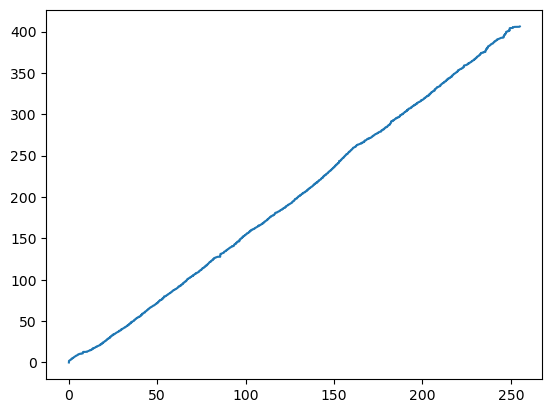

In [24]:
plt.plot(res[0], res[1])

In [25]:
query_list = 'cfg_files/query.test.list' # this was set to query.test.list in the segmentalDTW code. Can we run on test data? 
audio_dir = "../Chopin_Mazurkas/wav_22050_mono"
outdir = Path('experiments_test/MATCH_clean')
n_cores = 10
align_match_batch(query_list, audio_dir, outdir, n_cores)

Entered align_match_batch
Preparing inputs
Skipping experiments_test/MATCH_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Ax-1985_pid9179-07.pkl
Skipping experiments_test/MATCH_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Bacha-1998_pid9166e-08.pkl
Skipping experiments_test/MATCH_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Barbosa-1983_pid9174-15.pkl
Skipping experiments_test/MATCH_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Ben-Or-1989_pid9161-13.pkl
Skipping experiments_test/MATCH_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Biret-1990_pid9062-15.pkl
Skipping experiments_test/MATCH_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Brailowsky-1960_pid9060-15.pkl
Skipping experiments_test/MATCH_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op024No2_Chiu-1999_pid9048-15.pkl
Skipping experiments_test/MATCH_clean/Chopin_Op024No2_Ashkenazy-1981_pid9058-15__Chopin_Op0